# Fitting and Interpreting Cell-Cell Interaction Effect Models

From a pre-curated list of target genes, we can use Spateo's predictive modeling suite to predict whether/how a given ligand or ligand:receptor pair may be influencing expression of each of these genes. 

Briefly, these models are spatially-aware and also spatially-weighted, so as to account for possible regional heterogeneity within a tissue or organ. This has the bonus of being generally more accurate in reconstruction, and also opens doors to new possibilities for CCI analysis. Notably, featured in this tutorial, we can visualize the approximate regions within the tissue that a given signal is predicted to be active in upregulating a given target gene. We also give a brief overview of some of the additional basic downstream functions Spateo can accommodate. 

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Warning:</strong> We note that part of this tutorial depends on PyVista for visualization, which is not straightforward on Windows. However, this sections with "Visualization" in the title can be skipped over in this case.
</div>

In [1]:
import anndata
import pandas as pd
import spateo as st
import os

import pyvista as pv
pv.global_theme.transparent_background = False
# For Pyvista plotting in headless environment (Mac, Windows or Linux)
pv.start_xvfb()

2024-08-22 00:18:42.256648: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 00:18:42.293817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 00:18:42.952888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%config InlineBackend.print_figure_kwargs={'dpi': 300.0}

## Tutorial structure

In the case that the relevant files were not already downloaded (and the below directories already created) in the first portion of the cell-cell interaction effects modeling tutorial, three folders within the current working directory will contain all necessary files: "data", "database", and "analysis". The first will eventually contain the input data, the second will eventually contain the files that constitute Spateo's signaling database, and the third results of analyses and all necessary input files (here, the list of ligands and the list of target genes).

In [3]:
# Optionally, change the "working directory" here:
wd = "/home/danielyumengzhu/Spateo-tutorial"

os.chdir(wd)

In [ ]:
if not os.path.exists("./data"):
    os.mkdir("./data")

if not os.path.exists("./database"):
    os.mkdir("./database")

if not os.path.exists("./analysis"):
    os.mkdir("./analysis")

## Load data

As was mentioned in the target gene selection portion of this tutorial, in this tutorial, we will use data from a mouse embryo at the E11.5 developmental stage, obtained using the Stereo-seq method. 

All files can be loaded from the link below. 

[Mouse Embryo E11.5 ZLI datasets](https://www.dropbox.com/scl/fo/y7pkkonepa6lg9l09hu6i/AB1Ryb6VbElhCn2NKOXgW5Q?rlkey=jxcf34rbib9k324ftb8hn4i76&st=atcg0zve&dl=0)

<div style="background-color: #D9EDF7; padding: 10px; border-radius: 5px;">
<b>Note:</b> Once downloaded, place the file with the .h5ad extension into the "data" folder within your current working directory. This dataset focuses on the tissue on the anterior and posterior sides of the ZLI ("E11.5_ZLI"). This link also contains all files necessary for cell-cell interaction modeling.
Also found are two .txt files, containing lists of ligands ("zli_ligands.txt") and target genes for the model ("zli_targets.txt"), respectively. Once downloaded, place into the "CCI_inputs" subfolder of the "analysis" folder.
</div>

For this tutorial, we also need access to Spateo's databases. These can be found in the package folder, but they can also be found at the link below. For this tutorial, we will move the database directory to a "database" folder within the current working directory. In the case of downloading from the link, all files (human_GRN.csv, etc.) should be moved into a folder in the working directory with this name.

[CCI database files](https://www.dropbox.com/scl/fo/dcd95so9zhkb8lnjkkxep/ANwmkFeb-sgtS89leHQezlU?rlkey=saiul4j5rr1vt6lwjl4hirmwh&st=kipotkvm&dl=0)

In [4]:
e115_zli = anndata.read_h5ad("./data/E11.5_ZLI.h5ad")
e115_zli.uns["__type"] = "UMI"

### Initialize CCI model

We will first approximate reasonable bounds for the membrane-bound and secreted signaling molecules. To do so, we will determine the radius for which, on average, results in 27 neighbors for each cell (this was determined using volumetric calculations, see Methods and Materials for the Spateo paper- not currently published). 

In [ ]:
e115_zli_lb = st.tl.find_neighbors.find_bw_for_n_neighbors(
    e115_zli,
    coords_key="z_correction",
    n_anchors=2000,
    target_n_neighbors=27,
    initial_bw=20,
    exclude_self=True
)
e115_zli_lb

In [ ]:
e115_zli_ub = st.tl.find_neighbors.find_bw_for_n_neighbors(
    e115_zli,
    coords_key="z_correction",
    n_anchors=2000,
    target_n_neighbors=250,
    initial_bw=20,
    exclude_self=True
)
e115_zli_ub

<div style="background-color: #D9EDF7; padding: 10px; border-radius: 5px;">
<b>Note:</b> The format of "cci_output_id" is {full path}/containing_folder/{run_id}.csv, where "run_id" is any descriptive name to give the model. All outputs will be tagged with this ID. 
</div>

In [5]:
path_to_zli = "./data/E11.5_ZLI.h5ad"
cci_output_id = "./analysis/CCI_outputs/key_zli_genes/key_zli_genes.csv"
lr_db_path = "./database"

if not os.path.exists("./analysis/CCI_outputs/key_zli_genes"):
    os.mkdir("./analysis/CCI_outputs/key_zli_genes")

#### Notes on arguments and parameters

**mod_type**: There are three classes of possible model that essentially differ in how the modeling problem is set up. 
* "niche": Models gene expression in a cell as a function of the cell types that can be found in the neighborhood of that cell.
* "ligand": Models gene expression in a cell as a function of the expression of ligand genes by the cells in the local neighborhood. We recommend this option for sparse data scenarios, although it offers less interpretability compared to the "lr" option. 
* "lr": Models gene expression in a cell as a function of both the expression of receptors in the cell combined with expression of paired ligand genes by the cells in the local neighborhood.

**distr**: Sets the distributional assumption of the model. We recommend this to either be "poisson" or "nb", to best handle the discrete, skewed nature of RNA counts data.

**group_key**: The name of the .obs entry that contains the cell type information. 

**coords_key**: The name of the .obsm entry that contains spatial (x, y or x, y, z) information. 

**total_counts_key**, **total_counts_threshold** and **spatial_subsample** are used to make the modeling process more efficient, by fitting only to select cells (that pass the total counts threshold and/or are selected by the spatial subsampling process) and extending the inferred coefficients from these cells to their spatial neighbors. This typically comes with a slight accuracy tradeoff, but the fitting process should be significantly faster.

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Warning:</strong> Due to the size of this dataset (>100000 cells), this entire process can take a very long time! For tutorial purposes, we recommend shortening the list of target genes (see path ./analysis/CCI_inputs/zli_targets.txt).
</div>

In [6]:
adata_path = path_to_zli
output_path = cci_output_id
# Use the ligand/receptor paths from the model fitting:
ligand_path = "./analysis/CCI_inputs/zli_ligands.txt"
# In this tutorial, the receptor path will not actually be used, but to give an idea of how it would be incorporated:
receptor_path = "./analysis/CCI_inputs/zli_receptors.txt"
target_path = "./analysis/CCI_inputs/zli_targets.txt"
cci_dir_path = lr_db_path
mod_type = "ligand"
species = "mouse"
distr = "poisson"
group_key = "mapped_celltype"
coords_key = "z_correction"
distance_membrane_bound = 6.6
distance_secreted = 16.5
total_counts_key = "total_counts"
total_counts_threshold = 2000.0
# Effective radius for each cell that assumes cell size = 10um, diameter signaling range = 250um, and cells are not tightly packed, w/ a (erring on the larger side)
# distance of 30um between neighbors
minbw = 10.0
maxbw = 23.0
spatial_subsample = True

In [7]:
parser, args_list = st.tl.define_spateo_argparse(
    adata_path=adata_path,
    custom_lig_path=ligand_path,
    #custom_rec_path=receptor_path,
    targets_path=target_path,
    cci_dir=cci_dir_path,
    mod_type=mod_type,
    species=species,
    distr=distr,
    group_key=group_key,
    coords_key=coords_key,
    distance_membrane_bound=distance_membrane_bound,
    distance_secreted=distance_secreted,
    minbw=minbw,
    maxbw=maxbw,
    spatial_subsample=spatial_subsample,
    total_counts_key=total_counts_key,
    total_counts_threshold=total_counts_threshold,
    output_path=output_path,
)

<div style="background-color: #D9EDF7; padding: 10px; border-radius: 5px;">
<b>Note:</b> "adjust_for_subsampling" should be set to True in the case that "total_counts_threshold" or "spatial_subsample" is provided. 
</div>

In [ ]:
model = st.tl.MuSIC(parser, args_list)
model._set_up_model()
model.fit()
model.predict_and_save(adjust_for_subsampling=True)

### Initialize the downstream model

In [8]:
downstream_model = st.tl.MuSIC_Interpreter(parser, args_list)

------------------------------------------------------------
|-----> Spatial kernel: Adaptive Bisquare
|-----> Loading AnnData object from: ./data/E11.5_ZLI.h5ad
|-----> Model type: ligand
|-----> Loading cell-cell interaction databases from the following folder:  ./database.
|-----> Using list of custom ligands from: ./analysis/CCI_inputs/zli_ligands.txt.
|-----> Using list of target genes from: ./analysis/CCI_inputs/zli_targets.txt.
|-----> Saving all outputs to this directory: ./analysis/CCI_outputs/key_zli_genes.
|-----> Running :func `SWR._set_up_model()` to organize predictors and targets for downstream analysis now...
|-----> Found existing independent variable matrix, loading from ./analysis/CCI_outputs/key_zli_genes/key_zli_genes.csv/design_matrix/design_matrix.csv.
|-----> Checking for coefficients of possible downstream models as well...
|-----> Could not find downstream directory ./analysis/CCI_outputs/key_zli_genes/cci_deg_detection/receptor_analysis/downstream, this type 

### Visualize regions of predicted effect

In [9]:
img_out_dir = "./analysis/figures"

In [10]:
# "effector" can be given in the form "Wnt9a" corresponding to a ligand, or "Tgfb1:Tgfbr2" in the case that receptors were involved in the modeling process. 
effector = "Wnt9a"
target = "Axin2"

In [11]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyvista import PolyData, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

In [12]:
cci_effect_file = pd.read_csv(f"./analysis/CCI_outputs/key_zli_genes/key_zli_genes_{target}.csv", index_col=0)
# Get the specific column requested
cci_effect_file_col = cci_effect_file[f"b_{effector}"]

In [13]:
# We add Fgf8 as a key/use it for the groupby parameter just for initialization of the PyVista object- it doesn't matter what gene is used here
pc_model, _ = st.tdr.construct_pc(
    adata = e115_zli,
    spatial_key = "z_correction",
    groupby = "Fgf8",
    key_added = "Fgf8", 
    colormap = "Reds"
)

pc_model = st.tdr.rotate_model(model=pc_model, angle=(0, 0, 90), rotate_center= pc_model.center, inplace=False)
pc_model = st.tdr.rotate_model(model=pc_model, angle=(0, 180, 0), rotate_center= pc_model.center, inplace=False)
pc_model = st.tdr.rotate_model(model=pc_model, angle=(30, 0, 0), rotate_center= pc_model.center, inplace=False)

In [14]:
pc_index = pc_model.point_data["obs_index"].tolist()
vals = cci_effect_file_col.loc[pc_index].values.flatten()
vals[vals <= 0] = 0

In [15]:
amap = vals.copy()
amap = amap / np.max(amap)
amap[amap <= 0.005] = 0.1

add_model_labels(
    model = pc_model, 
    labels = vals, 
    key_added = f"{effector}_effect_on_{target}", 
    alphamap = amap, 
    where = "point_data",
    inplace = True, 
    colormap = "Reds"
)

(None, None)

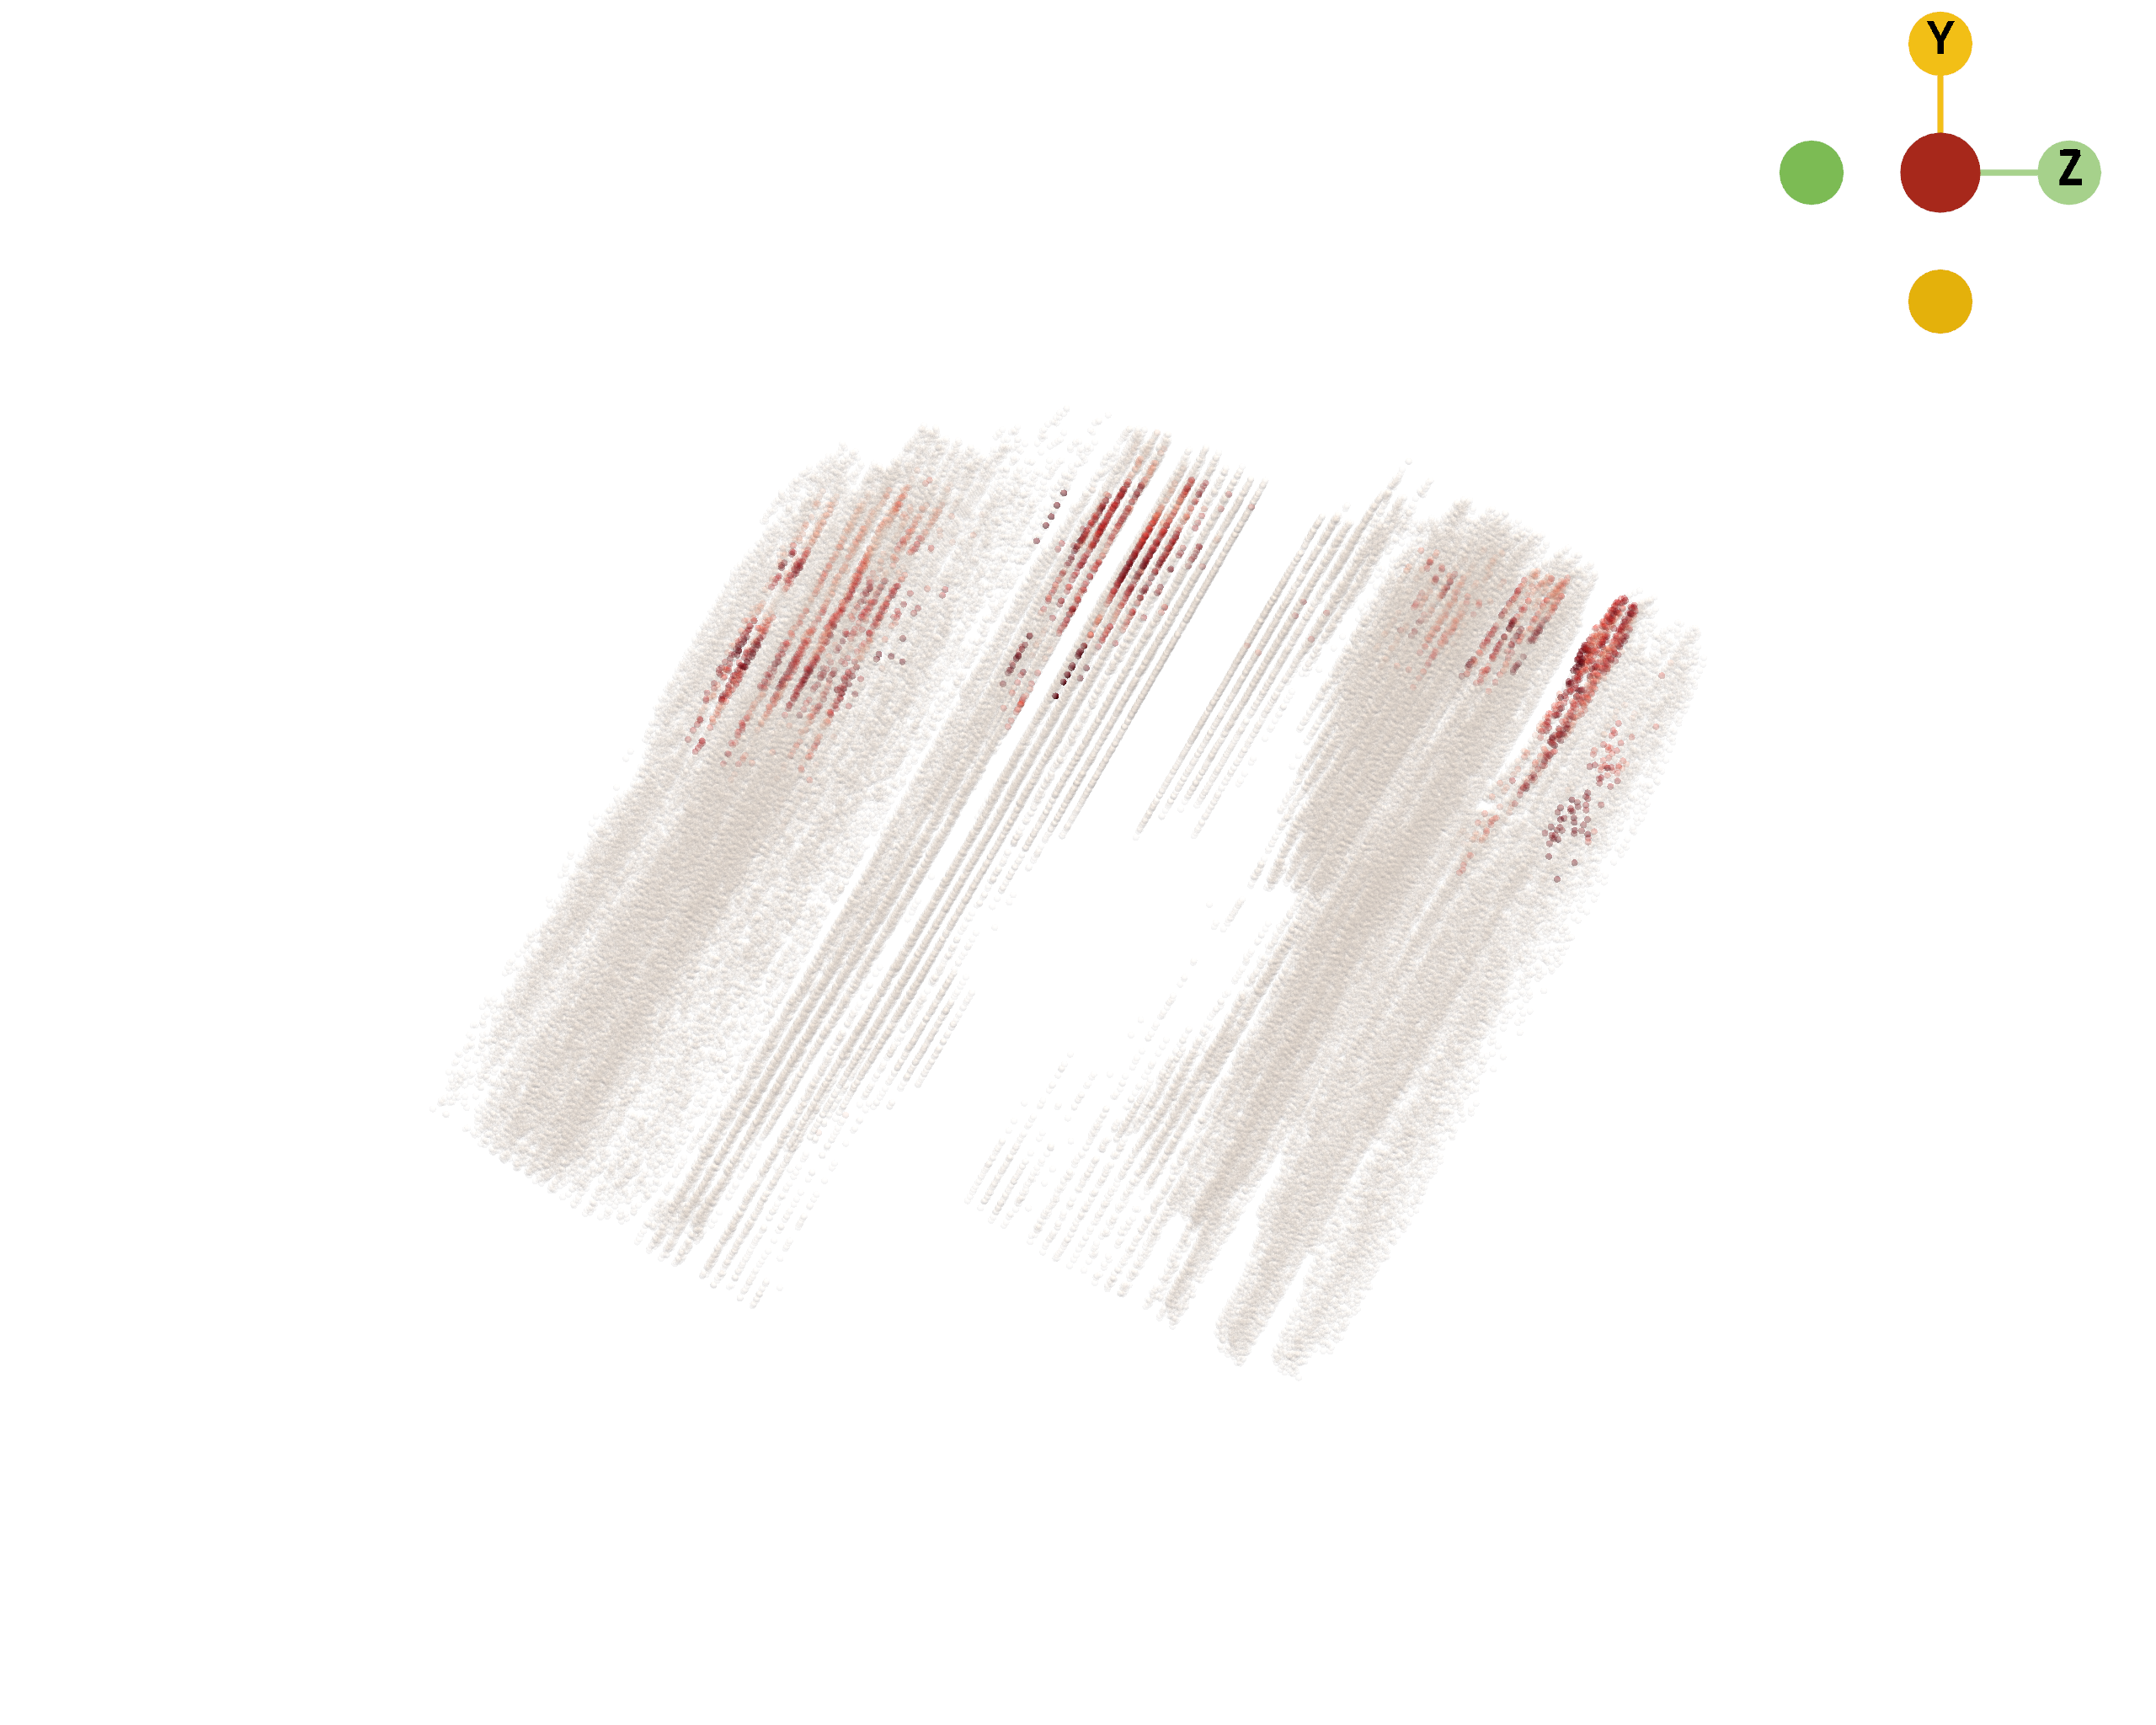

In [16]:
st.pl.three_d_plot(
    model = pc_model,
    key = f"{effector}_effect_on_{target}",
    model_style = "points",
    model_size = 8,
    opacity = 1,
    colormap = None,
    show_legend = True,
    jupyter = "static",
    off_screen = False,
    cpo = "zy",
    window_size = (2560, 2048),
    filename = os.path.join(img_out_dir, f"mouse_E11.5_{effector}_effect_on_{target}.tiff")
)

### Describe the spatial enrichment of ligands and target genes

Here, **position_key** is the key of the entry in .obsm to look at. However, this can also be an entry in .obs that stores numerical values. **coord_column** establishes the column of the .obsm array for which to compute spatial enrichment along (and is not applicable in the case that **position_key** refers to an entry in .obs). 

**window_size** sets the length of the smoothing kernel. 

**use_ligands** is a Flag that when set, will look at the ligands used as input to the model to create the spatial enrichment map. Similarly, **use_receptors** and **use_target_genes** are convenient options to easily set genes to visualize. 

Computing fold changes for each gene...:   0%|          | 0/101 [00:00<?, ?it/s]

|-----> Sorting by position of enrichment along axis...


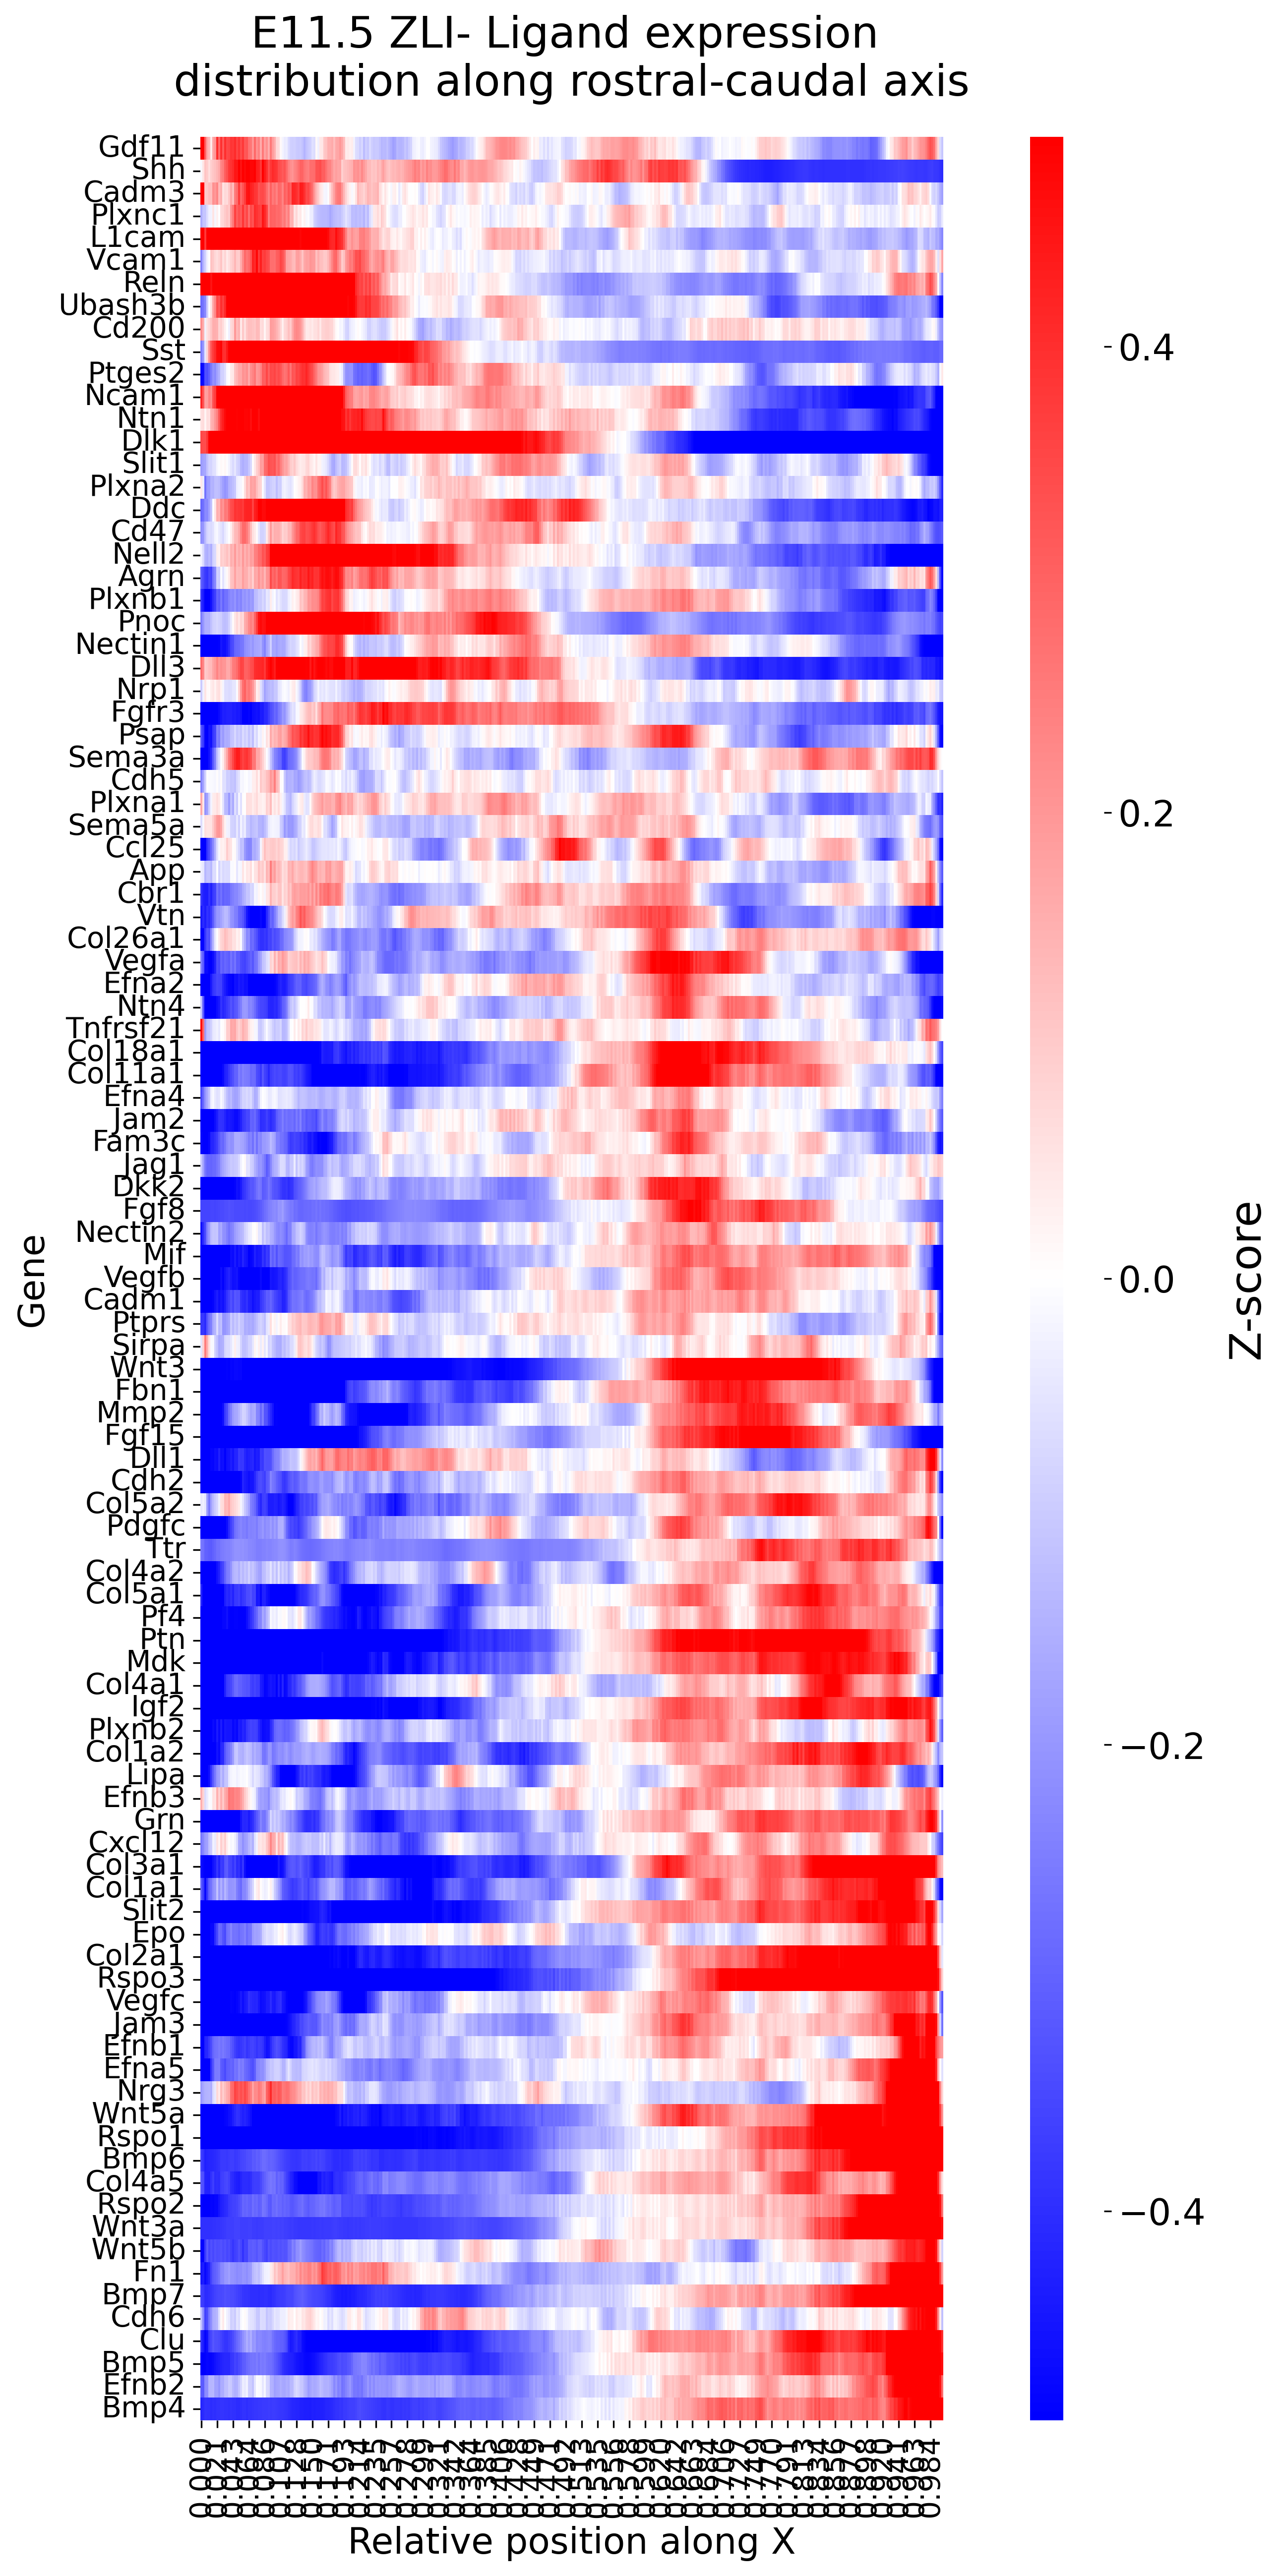

In [17]:
downstream_model.gene_expression_heatmap(
    use_ligands=True,
    position_key="z_correction",
    coord_column=0,
    neatly_arrange_y=True,
    cmap="bwr",
    title="E11.5 ZLI- Ligand expression \ndistribution along rostral-caudal axis",
    fontsize=14,
)

Computing fold changes for each gene...:   0%|          | 0/72 [00:00<?, ?it/s]

|-----> Sorting by position of enrichment along axis...


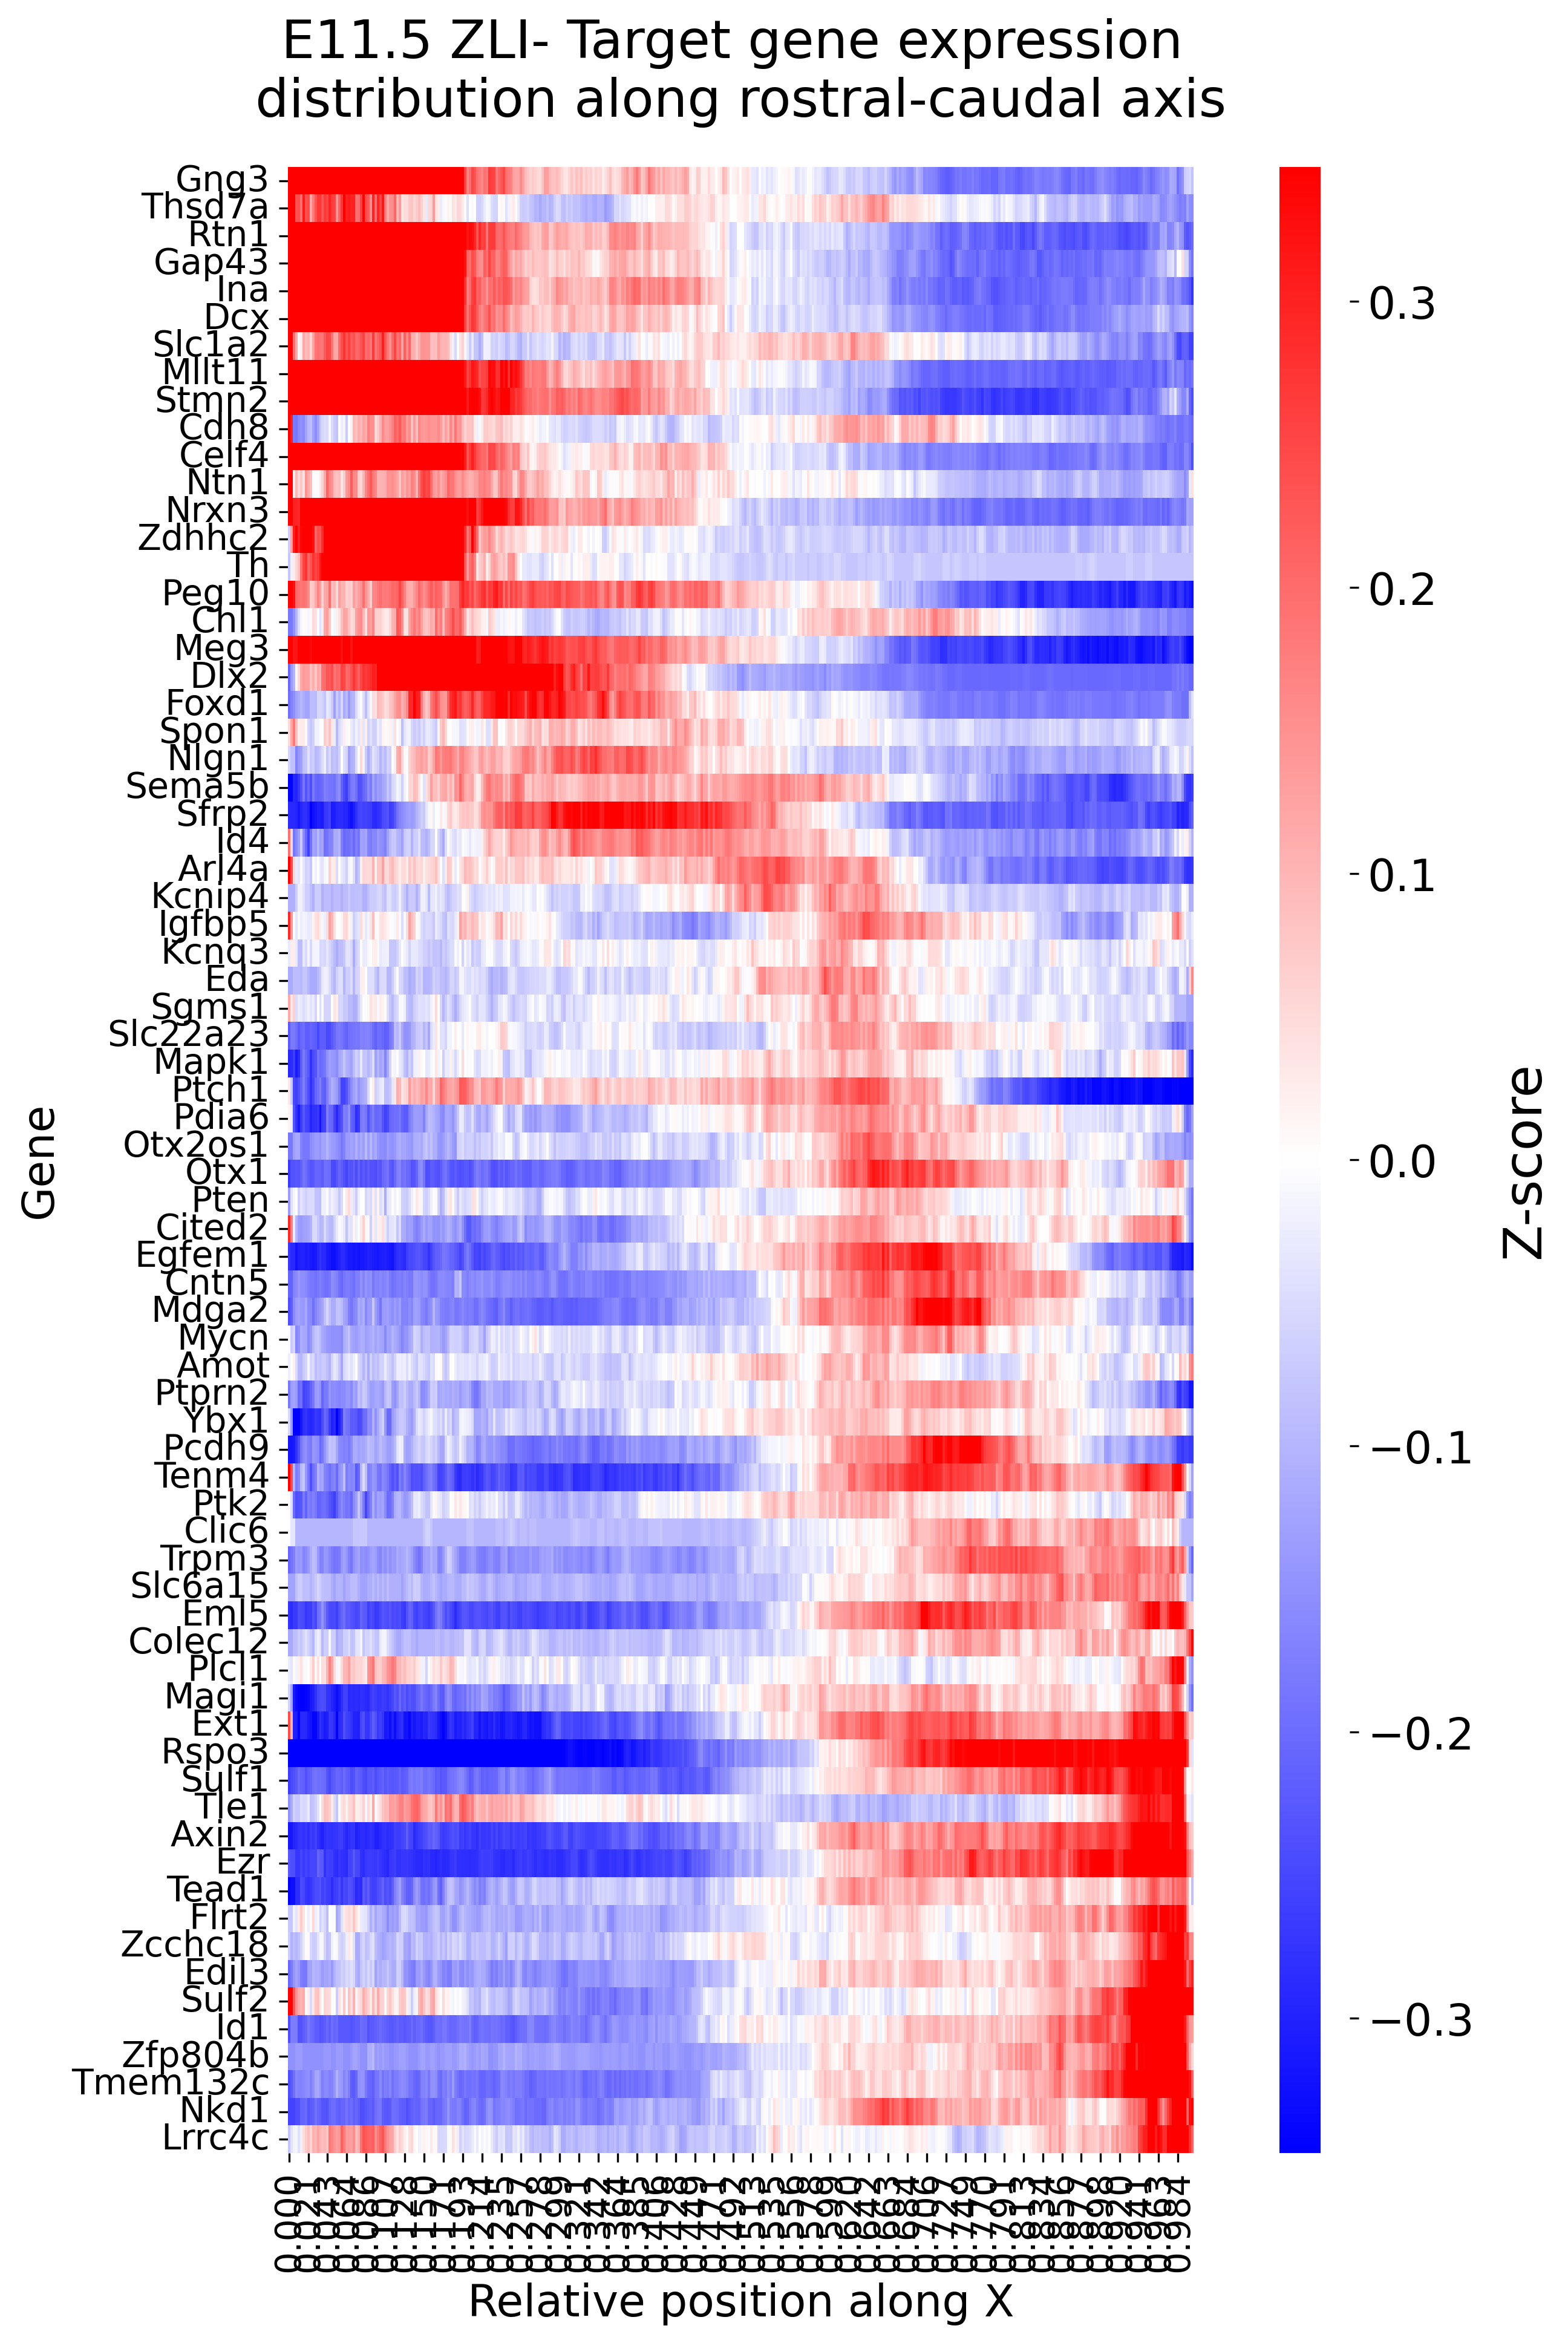

In [18]:
downstream_model.gene_expression_heatmap(
    use_target_genes=True,
    position_key="z_correction",
    coord_column=0,
    neatly_arrange_y=True,
    cmap="bwr",
    title="E11.5 ZLI- Target gene expression \ndistribution along rostral-caudal axis",
    fontsize=14,
)

In [19]:
# For a select subset of the target genes, use the "genes" parameter
targets = ["Meg3", "Gap43", "Stmn2", "Ina", "Gli3", "Glis3", "Spry1"]

Computing fold changes for each gene...:   0%|          | 0/7 [00:00<?, ?it/s]

|-----> Sorting by position of enrichment along axis...


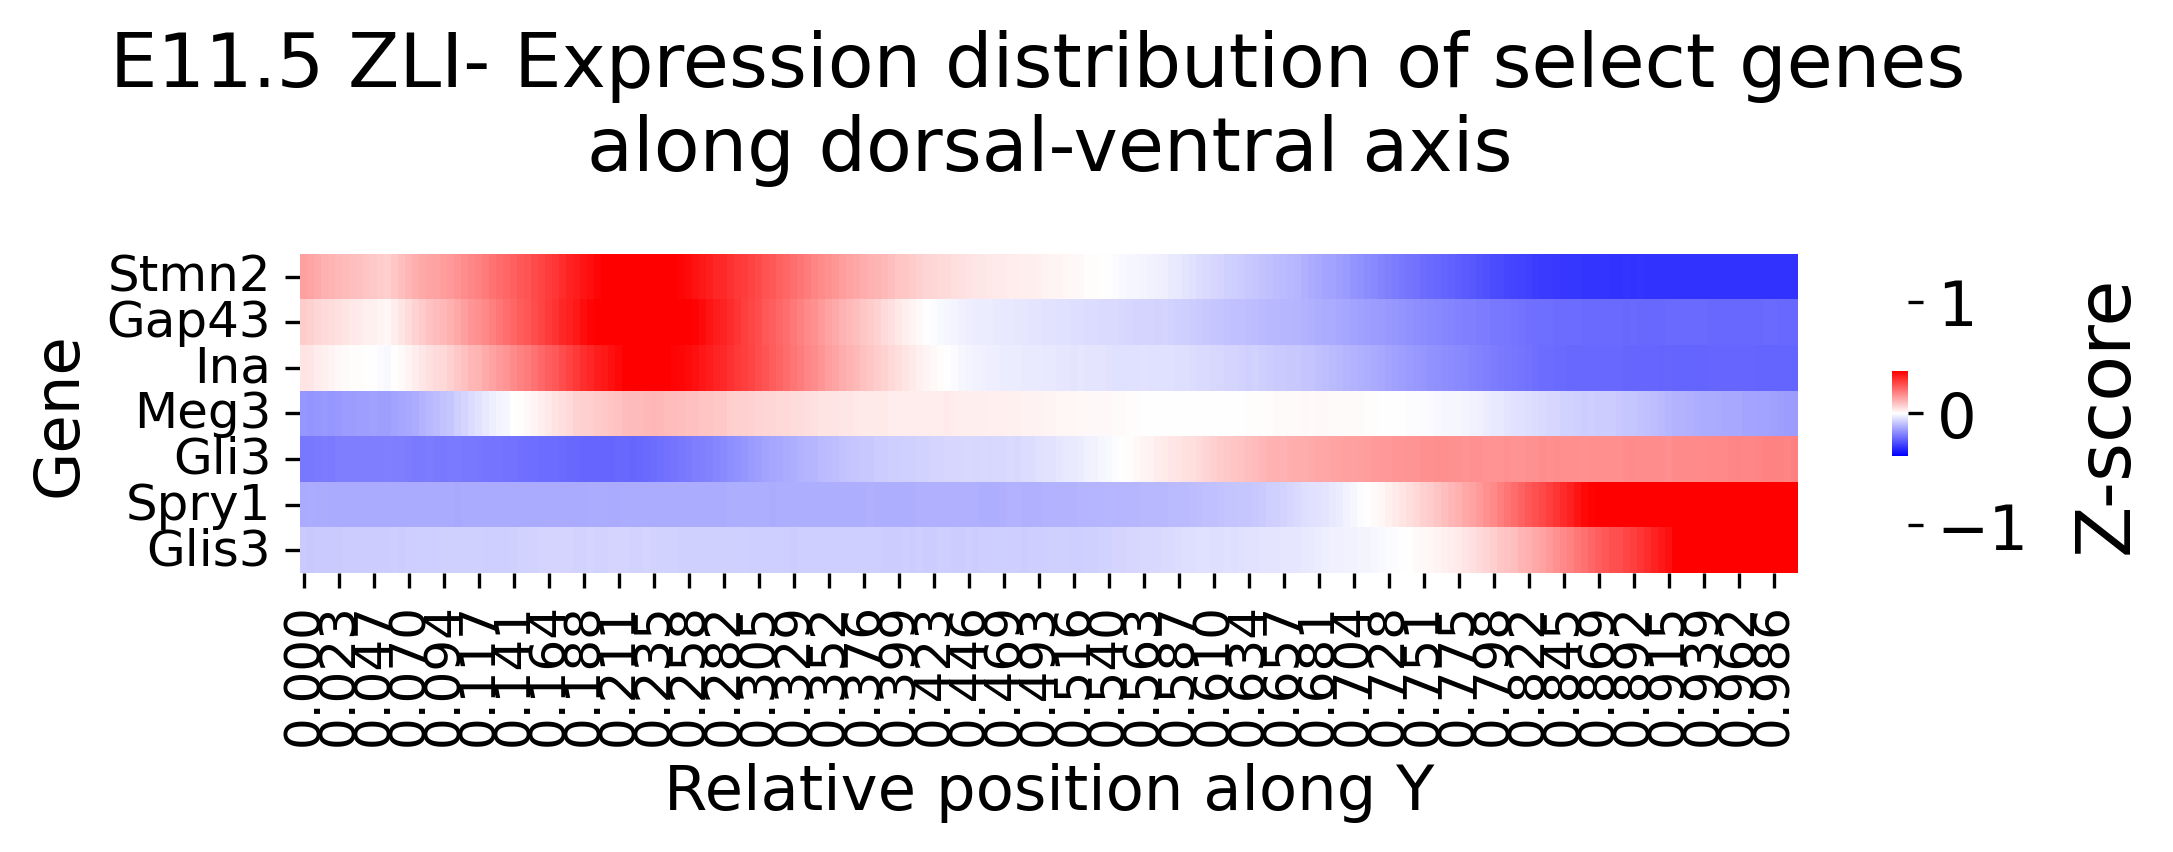

In [20]:
downstream_model.gene_expression_heatmap(
    genes=targets,
    position_key="z_correction",
    coord_column=1,
    neatly_arrange_y=True,
    cmap="bwr",
    recompute=True,
    window_size=35,
    title="E11.5 ZLI- Expression distribution of select genes \nalong dorsal-ventral axis",
    fontsize=12,
)

### Compute the density of select predicted interaction effects

#### Taking a look at the rostral-caudal axis

In [21]:
pc_model, _ = st.tdr.construct_pc(
    adata = e115_zli,
    spatial_key = "z_correction",
    groupby = "rc_coord",
    key_added = "rc_coord"
)

pc_model = st.tdr.rotate_model(model=pc_model, angle=(0, 0, 90), rotate_center= pc_model.center, inplace=False)
pc_model = st.tdr.rotate_model(model=pc_model, angle=(0, 180, 0), rotate_center= pc_model.center, inplace=False)
pc_model = st.tdr.rotate_model(model=pc_model, angle=(30, 0, 0), rotate_center= pc_model.center, inplace=False)

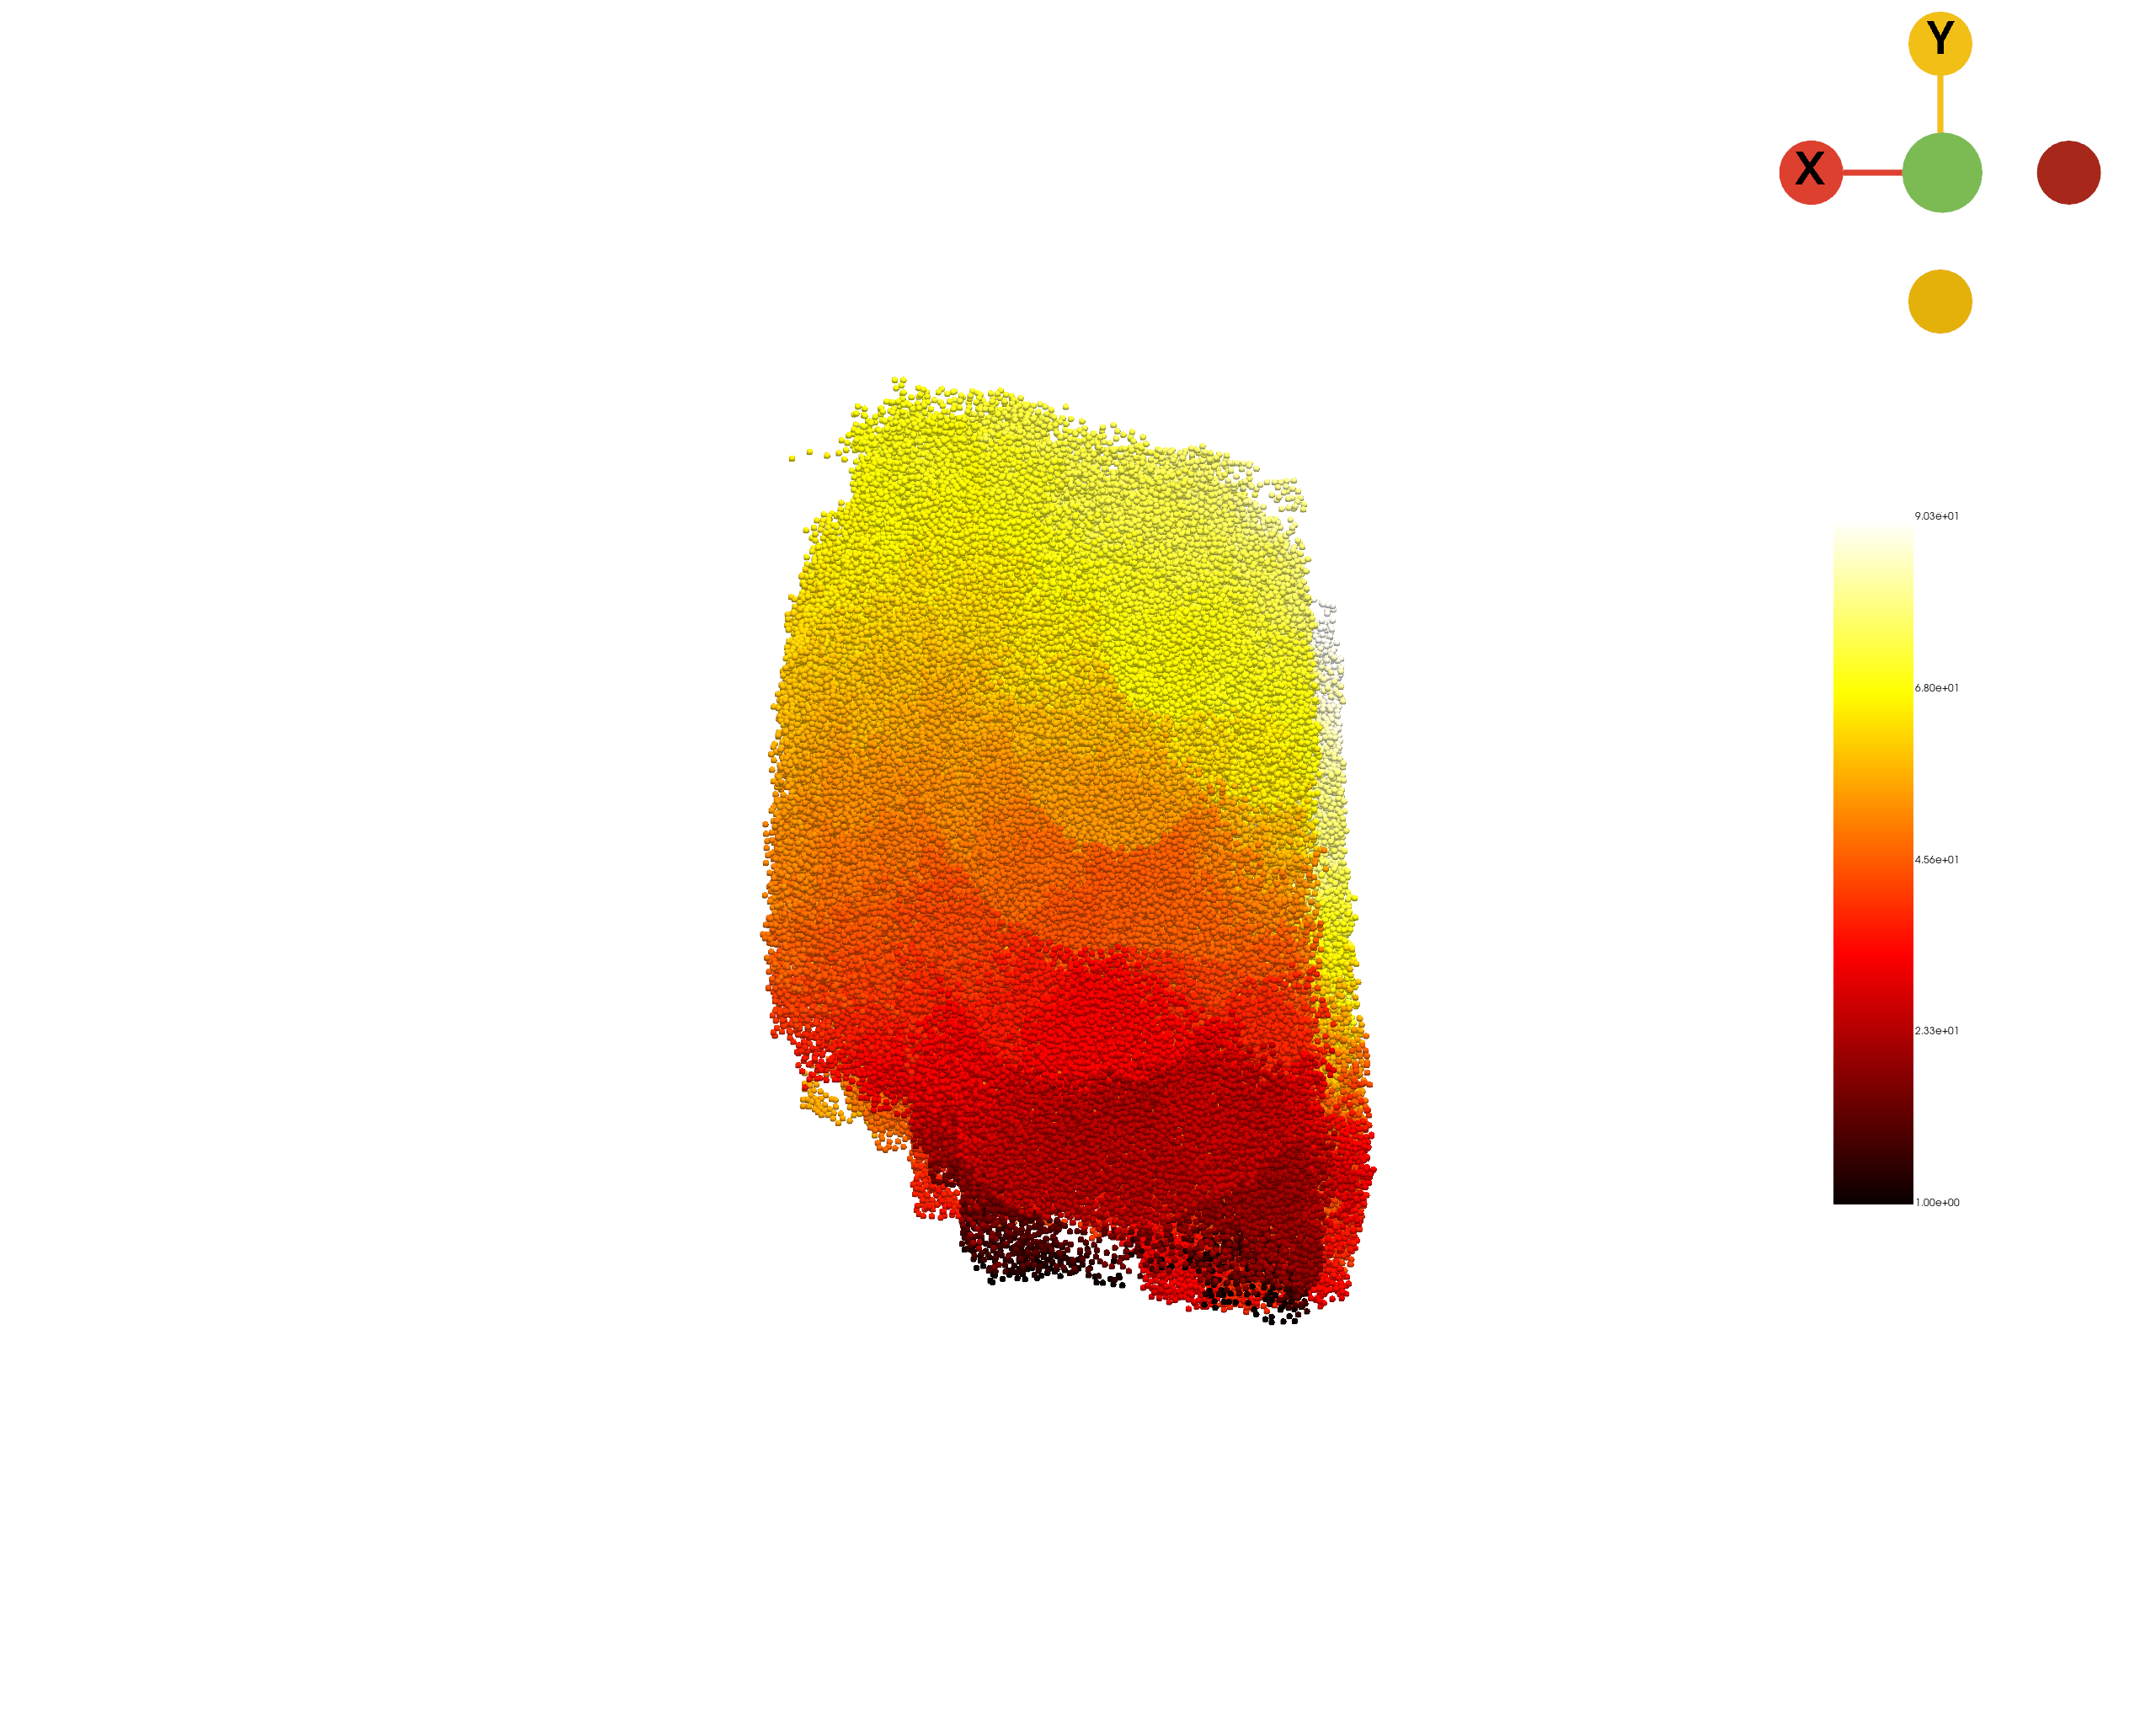

In [23]:
st.pl.three_d_plot(
    model = pc_model,
    key = "rc_coord",
    model_style ="points",
    model_size = 8,
    opacity = 1,
    colormap = "hot",
    show_legend = True,
    jupyter = "static",
    off_screen = False,
    cpo=[(1626, 481, -519), (1612, 481, 647), (0, 1, 0)],
    window_size = (2560, 2048),
    filename = "./analysis/figures/mouse_E11.5_ZLI_RC_coord.tiff"
)

In [24]:
# Choosing an example subset of ligand-target pairs for the following visualization:
pairs = ["Vegfa-Dcx", "Agrn-Th", "Slit2-Ina", "Bmp6-Ext1", "Bmp7-Id1", "Ptn-Gap43", "Agrn-Stmn2", "Bmp7-Eml5"]

In [25]:
def polarity(
    test_df,
    column_dict: dict,
    region_key: str,
    palette: list,
    mode: str = "density",
    itv_rpt: int = 1,
    width: int = 5,
    height: int = 3.5,
    region_lower_bound=None,  # Optional parameters for region bounds
    region_upper_bound=None,
):
    """Visualize data variation along regions using columns from a DataFrame.

    Args:
        test_df (DataFrame): Data to be visualized.
        column_dict (dict): Specifies columns to be visualized, potentially grouped by annotations.
        region_key (str): Column name in test_df indicating regions.
        mode (str, optional): Visualization mode ('density' or 'exp'). Defaults to "density".
        region_lower_bound (int, optional): Lower bound of the region to highlight.
        region_upper_bound (int, optional): Upper bound of the region to highlight.
    """
    import scipy.stats as stat
    digi_region = np.array([])
    column_list = np.array([])
    column_mean = np.array([])
    column_mean_low = np.array([])
    column_mean_high = np.array([])

    if mode == "exp":
        for i in np.unique(test_df[region_key]):
            df_tmp = test_df[test_df[region_key] == i]
            for anno in list(column_dict.keys()):
                for column in column_dict[anno]:
                    column_mean_tmp = df_tmp[column].to_numpy()
                    digi_region = np.append(digi_region, np.repeat(i, len(df_tmp)))
                    column_list = np.append(column_list, np.repeat(column + " " + anno, len(df_tmp)))
                    column_mean = np.append(column_mean, column_mean_tmp)
        df_plt = pd.DataFrame({region_key: digi_region, "Column": column_list, "Mean value": column_mean})
        ax = sns.relplot(data=df_plt, x=region_key, y="Mean value", hue="Column")
    elif mode == "density":
        for i in np.unique(test_df[region_key]):
            df_tmp = test_df[test_df[region_key] == i]
            for anno in list(column_dict.keys()):
                for column in column_dict[anno]:
                    digi_region = np.append(digi_region, i)
                    column_list = np.append(column_list, column + " " + anno)
                    column_mean = np.append(column_mean, np.mean(df_tmp[column]))
                    data = df_tmp[column].to_numpy()
                    data = np.repeat(data, itv_rpt)
                    l, h = stat.t.interval(alpha=0.7, df=len(data)-1, loc=np.mean(data), scale=stat.sem(data))
                    if np.isnan(l):
                        l = np.mean(data)
                    if np.isnan(h):
                        h = np.mean(data)
                    column_mean_low = np.append(column_mean_low, max(0, l))
                    column_mean_high = np.append(column_mean_high, h)
        column_mean_low = column_mean_low + 1e-10
        column_mean_high = column_mean_high + 1e-10
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean})
        df_plt['Avg. effect'] = df_plt['Avg. effect'].clip(lower=0)
        plt.figure()
        p1 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p1.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean_low})
        plt.figure()
        p2 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p2.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        df_plt = pd.DataFrame({region_key: digi_region, "Interaction": column_list, "Avg. effect": column_mean_high})
        plt.figure()
        p3 = sns.kdeplot(data=df_plt, x=region_key, common_norm=False, weights="Avg. effect", hue="Interaction", linewidth=3)
        #p3.set_xlim(0, max(adata.obs[region_key]))
        plt.close()
        fig, ax = plt.subplots()
        fig.set_size_inches((width, height))
        uq_cl = np.unique(column_list)
        for k in range(len(uq_cl)):
            ax.plot(p1.get_children()[k].get_data()[0], p1.get_children()[k].get_data()[1], '-', color=palette[len(palette)-k-1])
            ax.fill_between(
                p1.get_children()[k].get_data()[0],
                p2.get_children()[k].get_data()[1]*np.sum(column_mean_low[column_list==uq_cl[-(k+1)]]) / np.sum(column_mean[column_list==uq_cl[-(k+1)]]),
                p3.get_children()[k].get_data()[1]*np.sum(column_mean_high[column_list==uq_cl[-(k+1)]])/ np.sum(column_mean[column_list==uq_cl[-(k+1)]]), color=palette[len(palette)-k-1], alpha=0.2)

        if region_lower_bound is not None and region_upper_bound is not None:
            plot_width = region_upper_bound - region_lower_bound
            region_box = mpl.patches.Rectangle(
                (region_lower_bound, ax.get_ylim()[0]),
                plot_width,
                ax.get_ylim()[1] - ax.get_ylim()[0],
                linewidth=1,
                edgecolor="#1CE6FF",
                facecolor="#1CE6FF",
                alpha=0.1,
            )
            ax.add_patch(region_box)
    return ax

In [26]:
temp_df = pd.DataFrame(0, index=e115_zli.obs_names, columns=pairs) 

for pair in pairs:
    file_path = f"{cci_output_id[:-4]}_{pair.split('-')[1]}.csv"
    coeffs_df = pd.read_csv(file_path, index_col=0)
    temp_df[pair] = coeffs_df[f"b_{pair.split('-')[0]}"]

In [27]:
ax = e115_zli.obsm["z_correction"][:, 0]
ax = (ax - ax.min()) / (ax.max() - ax.min()) * 100
ax = ax.astype(int)
temp_df["rc_coord"] = ax

In [28]:
# Guide: 
# Vegfa-Dcx = blue
# Ptn-Gap43 = orange
# Agrn-Th = green
# Slit2-Ina = red
# Bmp6-Ext1 = purple
# Agrn-Stmn2 = brown
# Bmp7-Eml5 = pink
# Bmp7-Id1 = grey

column_dict = {
    "1": ["Vegfa-Dcx"],
    "2": ["Ptn-Gap43"],
    "3": ["Agrn-Th"],
    "4": ["Slit2-Ina"],
    "5": ["Bmp6-Ext1"],
    "6": ["Agrn-Stmn2"],
    "7": ["Bmp7-Eml5"],
    "8": ["Bmp7-Id1"],
}

In [30]:
import matplotlib as mpl
import seaborn as sns
palette = [mpl.colors.to_hex(i) for i in sns.color_palette("tab10" ,n_colors=len(column_dict))]
palette

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f']

/tmp/ipykernel_4938/3498202625.py:51: DeprecationWarning:

Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning:

invalid value encountered in multiply

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/danielyumengzhu/spateo_env/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide



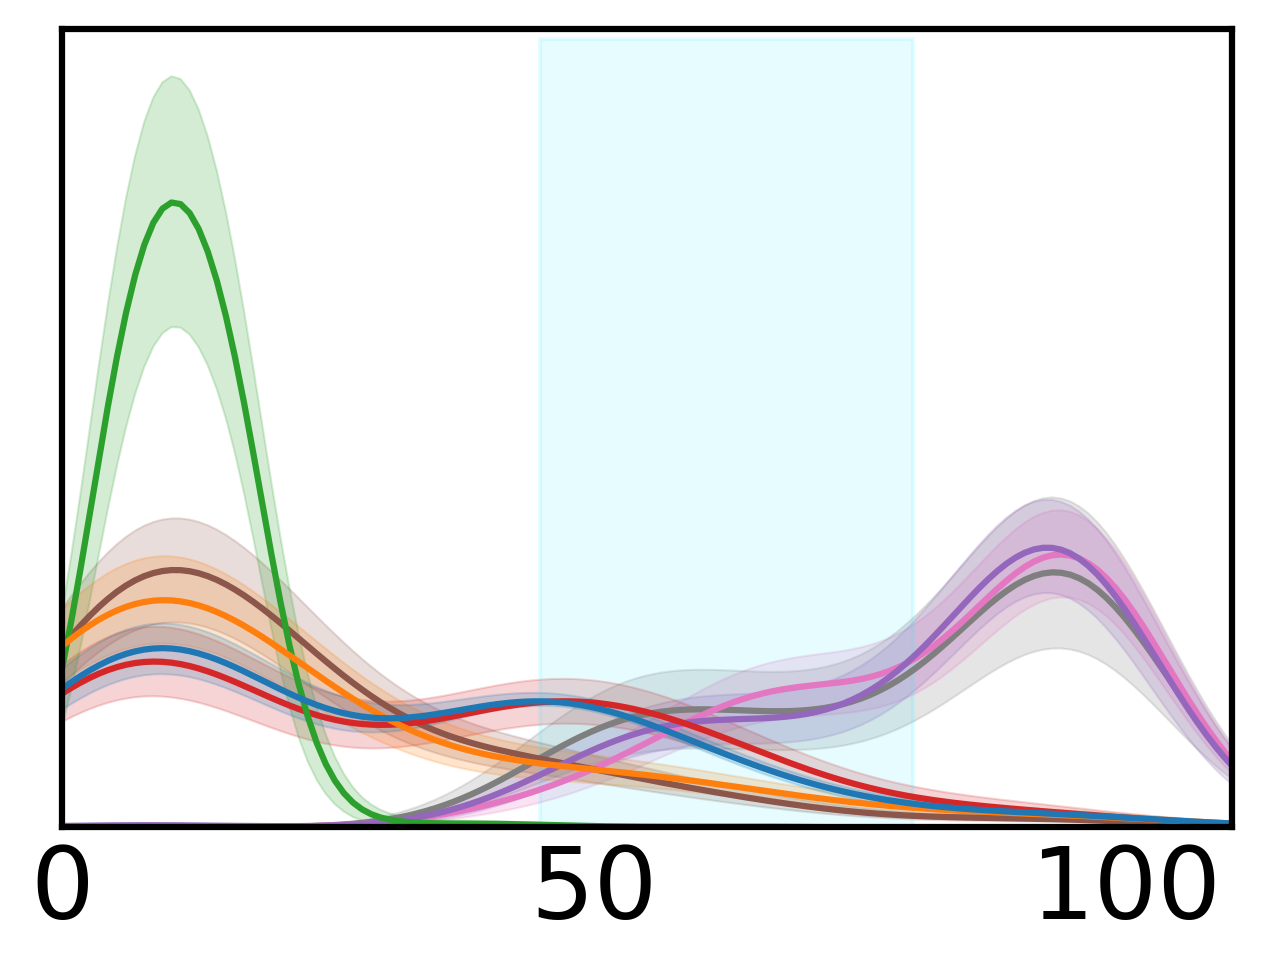

In [31]:
ax = polarity(temp_df, column_dict, region_key="rc_coord",
              palette=palette,
              itv_rpt=1,
              region_lower_bound=45,
              region_upper_bound=80,
             )
ax.tick_params(direction="out")
ax.set_yticks([])
ax.tick_params(axis='x', length=0, labelsize=24)
plt.xlim([0, 110])
plt.ylim([0.00, 0.075])

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

Again as a guide: 
* Vegfa-Dcx = blue
* Ptn-Gap43 = orange
* Agrn-Th = green
* Slit2-Ina = red
* Bmp6-Ext1 = purple
* Agrn-Stmn2 = brown
* Bmp7-Eml5 = pink
* Bmp7-Id1 = grey

In [ ]:
plt.savefig("./analysis/figures/KDE_CCI_effects.pdf", bbox_inches = "tight", transparent=True, width=2, height=1)

### Run TF-target models

For integration of the inferred intercellular signaling effects with intracellular (transcription factor-target) predictions, we can leverage the functionalities of Spateo's downstream model. The visualization method for CCI effects can also be used for TF-target predictions, although these are potentially less spatially-enriched. 

**use_ligands** is a Flag that when set, will focus on the ligands for this downstream model. Similarly, **use_receptors** and **use_target_genes** operate similarly. 

Within the folder we created earlier ("./analysis/CCI_outputs/key_zli_genes") this will create a "cci_deg_detection" folder, which will become populated with "ligand_analysis", "target_gene_analysis" folders, etc. depending on which set of genes we fit to. 

In [ ]:
downstream_model.CCI_deg_detection_setup(
    group_key="mapped_celltype",
    use_ligands=False,
    use_receptors=False,
    use_targets=True
)

In [ ]:
downstream_model.CCI_deg_detection(
    group_key="mapped_celltype",
    cci_dir_path=cci_dir_path,
    use_ligands=False,
    use_receptors=False,
    use_targets=True,
    use_dim_reduction=False,
    distr="poisson"
)